#### Note: the results from this notebook will not be exactly the same as the ones in the paper since we are using synthetic data.

### Install required packages

In [ ]:
!python3 -m pip install lightgbm xgboost interpret seaborn tueplots

### Set up the experiments

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (make_scorer, accuracy_score, balanced_accuracy_score, 
                             roc_auc_score, precision_score, recall_score, f1_score)
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate, KFold
from sklearn.svm import LinearSVC

from tueplots import axes, bundles, cycler, figsizes, fonts
from tueplots.constants import markers
from tueplots.constants.color import palettes

from lightgbm import LGBMClassifier
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from xgboost import XGBClassifier


# Dict of input features for each NCd prediction
FEATURE_DICT = {'DM' : ['DM_ICD10', 'DM_drugs', 
                        'Glucose', 'Glycohemoglobin (HbA1c)', 'eGFR', 'DM_key', 'IFG_key'],
                'HTN' : ['HTN_ICD10', 'HTN_drugs', 'HTN_key', 'cvd_key', 'sbp1', 'dbp1'],
                'CKD' : ['CKD_ICD10', 'CKD_drugs', 'CKD_key', 'eGFR', 'HTN_pred', 'DM_pred'],
                'DLP' : ['DLP_ICD10', 'DLP_drugs', 'DLP_key', 'LDL-c', 'HTN_pred', 'DM_pred', 'CKD_pred']
               }

scoring = {'Accuracy' : make_scorer(accuracy_score), 
           'Balanced accuracy score' : make_scorer(balanced_accuracy_score), 
           'Precision' : make_scorer(precision_score),
           'Recall' : make_scorer(recall_score), 
           'F1-score' : make_scorer(f1_score),
           'AUC' : make_scorer(roc_auc_score)
          }

scores = {'Accuracy' : accuracy_score, 
          'Balanced accuracy score' : balanced_accuracy_score, 
          'Precision' : precision_score,
          'Recall' : recall_score, 
          'F1-score' : f1_score,
          'AUC' : roc_auc_score
         }

# Dict of the performance metrics
result_dict = {'Accuracy': {'DM': {}, 'HTN': {}, 'CKD': {}, 'DLP': {}}, 
               'Balanced accuracy score': {'DM': {}, 'HTN': {}, 'CKD': {}, 'DLP': {}},
               'Precision': {'DM': {}, 'HTN': {}, 'CKD': {}, 'DLP': {}}, 
               'Recall': {'DM': {}, 'HTN': {}, 'CKD': {}, 'DLP': {}},
               'F1-score': {'DM': {}, 'HTN': {}, 'CKD': {}, 'DLP': {}},
               'AUC': {'DM': {}, 'HTN': {}, 'CKD': {}, 'DLP': {}}
              }

# Add some input features for DLP predictions
def dlp_features(X):
    X['DLP_1'] = X.apply(lambda x: (x['DM_pred'] == 1 and
                                    x['AGE'] >= 40 and
                                    x['LDL-c'] > 100),
                         axis=1).astype(int)
    X['DLP_2'] = X.apply(lambda x: (x['CKD_pred'] == 1 and
                                    x['AGE'] >= 50 and
                                    x['LDL-c'] > 100),
                         axis=1).astype(int)
    X['DLP_3'] = X.apply(lambda x: (x['AGE'] >= 21 and
                                    x['LDL-c'] >= 130),
                         axis=1).astype(int)
    X['DLP_4'] = X[['DLP_1', 'DLP_2', 'DLP_3', 'DLP_ICD10', 'DLP_drugs', 'DLP_key']].max(axis=1)
    
    return X

kfold = KFold(n_splits=5)

df = pd.read_csv('NCD_synthetic_labeled.csv', index_col=0)

### Train an Explainable Boosting Machine model

In [2]:
# To train EBM, we need to specify the type of each feature
type_dict = {'DM' : ['categorical', 'categorical', 
                     'continuous', 'continuous', 'continuous', 'categorical', 'categorical'],
                'HTN' : ['categorical', 'categorical', 
                         'categorical', 'categorical', 'continuous', 'continuous'],
                'CKD' : ['categorical', 'categorical', 'categorical', 'continuous', 'categorical', 'categorical'],
                'DLP' : ['categorical', 'categorical', 'categorical', 'continuous', 
                         'categorical', 'categorical', 'categorical']
               }

model_name = 'EBM (ours)'

with open("saved_models/EBM_parameters.pickle", "rb") as _f:
    param_dict = pickle.load(_f) 

for i, ncd in enumerate(['DM', 'HTN', 'CKD', 'DLP']):
    
    if ncd == 'DLP':
        df = dlp_features(df)
    
    features = FEATURE_DICT[ncd]

    X = df[features]
    y = df[ncd + '_label']

    params = param_dict[ncd]
    
    results = {'Accuracy': [], 
               'Balanced accuracy score': [],
               'Precision': [], 
               'Recall': [],
               'F1-score': [],
               'AUC': []
              }
    df[ncd + '_pred'] = 0
    for train_index, test_index in kfold.split(X):
        Xtrain = X.iloc[train_index, :]
        Xtest = X.iloc[test_index, :]
        ytrain = y.iloc[train_index]
        ytest = y.iloc[test_index]
        
        model = ExplainableBoostingClassifier()
        model.set_params(**params)
        ypred = model.fit(Xtrain, ytrain).predict(Xtest)
        df.loc[df.index[test_index], ncd + '_pred'] = ypred
        mispred = df.iloc[test_index, :][df.iloc[test_index, :][ncd+'_label'] != df.iloc[test_index, :][ncd+'_pred']]
        for score in scores:
            results[score].append(scores[score](ytest, ypred))
        
    for metric in scoring:
        result_dict[metric][ncd][model_name] = {'mean': np.mean(results[metric]), 
                                                'std': np.std(results[metric])}

### Train XGBoost, Light Gradient Boosting, Random Forest and Support Vector Machine

In [3]:
model_names = ['XGB', 'LGBM', 'RF', 'SVM']
models = [XGBClassifier(),
          LGBMClassifier(),
          RandomForestClassifier(),
          LinearSVC()]

for m in range(4):
    with open("saved_models/"+model_names[m]+"_parameters.pickle", "rb") as _f:
        param_dict = pickle.load(_f)
        
    for i, ncd in enumerate(['DM', 'HTN', 'CKD', 'DLP']):
        if ncd == 'DLP':
            df = dlp_features(df)

        features = FEATURE_DICT[ncd]

        X = df[features]
        y = df[ncd + '_label']

        model = models[m]
        params = param_dict[ncd]

        model.set_params(**params)
        results = cross_validate(estimator=model,
                                 X=X,
                                 y=y,
                                 cv=kfold,
                                 scoring=scoring,
                                 return_estimator=True)
        df[ncd + '_pred'] = 0
        for i, j in enumerate(kfold.split(y)):
            df.loc[df.index[j[1]], ncd + '_pred'] = results['estimator'][i].predict(X.iloc[j[1], :])
        for metric in scoring:
            result_dict[metric][ncd][model_names[m]] = {'mean': np.mean(results['test_'+metric]), 
                                                        'std': np.std(results['test_'+metric])}
     

### Rule-Based

In [4]:
model_name = 'RuleBased'

# Rule for DM
df['DM_1'] = df.apply(lambda x: (x['Glucose'] >= 126 
                                   or x['Glycohemoglobin (HbA1c)'] >= 6.5), 
                       axis=1).astype(int)
df['DM_2'] = df[['DM_1', 'DM_ICD10', 'DM_drugs', 'DM_key', 'IFG_key']].max(axis=1)

# Rule for HTN
df['HTN_1'] =  pd.concat([((df['sbp1'] >= 140) | (df['dbp1'] >=90)).astype(int),
                             df[['HTN_ICD10', 'HTN_drugs', 'HTN_key', 'cvd_key']]],
                             axis=1).max(axis=1)

# Rule for CKD
df['CKD_1'] = pd.concat([(df['eGFR'] < 60).astype(int),
                            df[['CKD_ICD10', 'CKD_drugs', 'CKD_key']]],
                           axis=1).max(axis=1)

# Rule for DLP
df['DLP_1'] = df.apply(lambda x: (x['DM_2'] == 1 and
                                  x['AGE'] >= 40 and
                                  x['LDL-c'] > 100),
                         axis=1).astype(int)
df['DLP_2'] = df.apply(lambda x: (x['CKD_1'] == 1 and
                                  x['AGE'] >= 50 and
                                  x['LDL-c'] > 100),
                         axis=1).astype(int)
df['DLP_3'] = df.apply(lambda x: (x['AGE'] >= 21 and
                                  x['LDL-c'] >= 130),
                         axis=1).astype(int)
df['DLP_4'] = df[['DLP_1', 'DLP_2', 'DLP_3', 'DLP_ICD10', 'DLP_drugs', 'DLP_key']].max(axis=1)

pred_col = {'DM': 'DM_2', 'HTN': 'HTN_1', 'CKD': 'CKD_1', 'DLP': 'DLP_4'}

for i, ncd in enumerate(['DM', 'HTN', 'CKD', 'DLP']):
    
    
    features = FEATURE_DICT[ncd]

    X = df[features]
    y = df[ncd + '_label']
    
    results = {'Accuracy': [], 
               'Balanced accuracy score': [],
               'Precision': [], 
               'Recall': [],
               'F1-score': [],
               'AUC': []
              }
    df[ncd + '_pred'] = 0
    for train_index, test_index in kfold.split(X):
        Xtrain = X.iloc[train_index, :]
        Xtest = X.iloc[test_index, :]
        ytrain = y.iloc[train_index]
        ytest = y.iloc[test_index]
        
        ypred = df.loc[df.index[test_index], pred_col[ncd]]
        df.loc[df.index[test_index], ncd + '_pred'] = ypred
        for score in scores:
            results[score].append(scores[score](ytest, ypred))
        
    for metric in scoring:
        result_dict[metric][ncd][model_name] = {'mean': np.mean(results[metric]), 
                                                'std': np.std(results[metric])}
    

### Plot the performance results

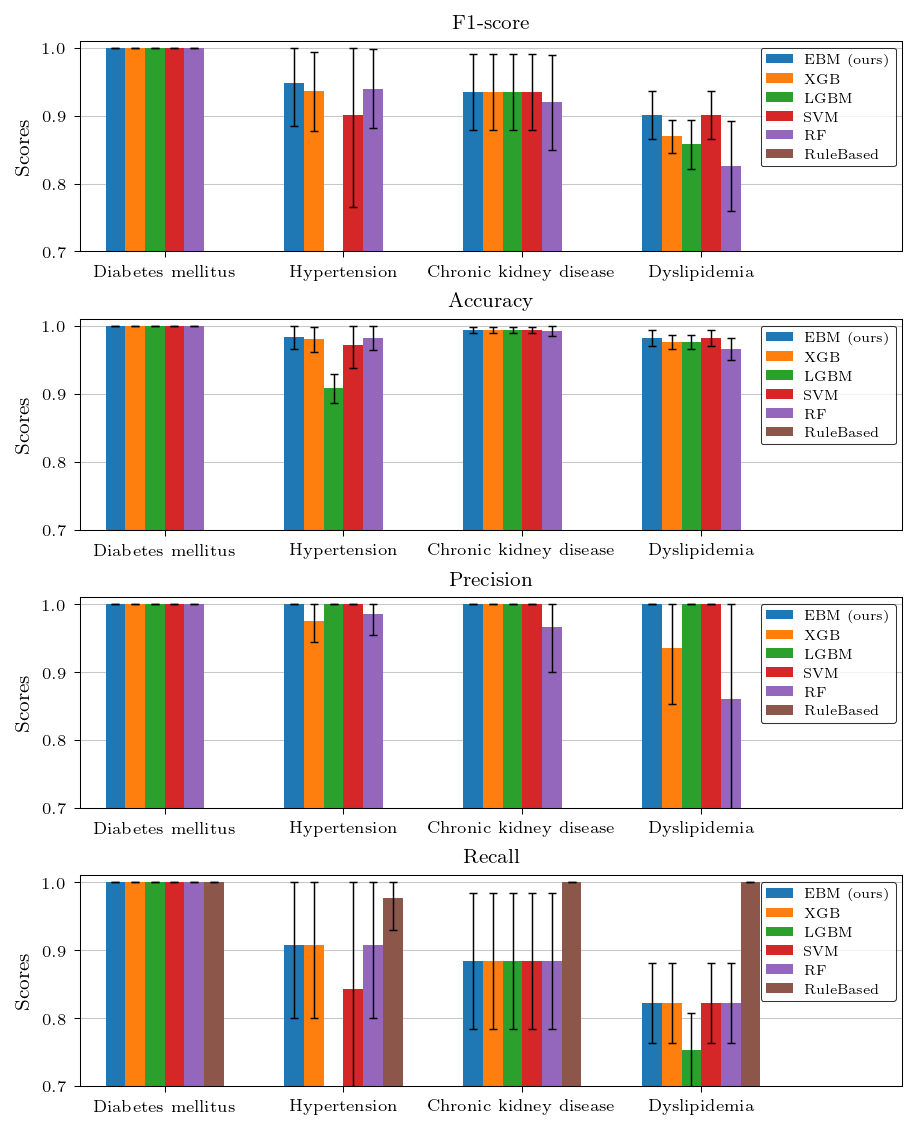

<Figure size 900x1112.46 with 0 Axes>

In [6]:
# might have to run this code block twice to show the plot properly
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"figure.dpi": 150})
plt.rcParams.update(fonts.jmlr2001_tex(family="serif"))
plt.rcParams.update(bundles.jmlr2001(family="serif"))
plt.rcParams.update(figsizes.jmlr2001(nrows=4))
plt.rcParams.update(cycler.cycler(color=sns.color_palette("tab10")))
plt.rcParams.update(axes.lines())
plt.rcParams.update(axes.grid(grid_alpha=0.7))
plt.rcParams.update({'legend.fontsize': 6.5,
                     'legend.handlelength': 2
                    }
                   )
  
N = 4
ind = np.arange(N) 
width = 0.11
labels = ['DM', 'HTN', 'CKD', 'DLP']
models = ['EBM (ours)', 'XGB', 'LGBM', 'SVM', 'RF', 'RuleBased']
bars = [None]*len(models)

fig, axs = plt.subplots(nrows=4, ncols=1)
plt.figure()
for ax,metric in zip(axs.flatten(),['F1-score', 'Accuracy', 'Precision', 'Recall']):

    ax.grid(axis='y')
    for i, model in enumerate(models):
        vals = np.array([result_dict[metric][label][model]['mean'] for label in labels])
        stds = np.array([result_dict[metric][label][model]['std'] for label in labels])
        errs = [stds, stds - np.maximum(vals + stds - 1, 0)]
        bars[i] = ax.bar(ind+width*i, 
                          vals, 
                          width, 
                          yerr=errs, 
                          error_kw=dict(lw=0.7, capsize=2, capthick=0.7, zorder=1), 
                          alpha=1)

    #plt.axhline(y=1, color='black', linestyle='--', linewidth=0.6, alpha=0.7)
    #plt.xlabel('NCD')
    ax.set_ylabel('Scores')
    ax.set_title(metric)

    ax.set_xlim(-0.2, 4.4)
    ax.set_xticks(ind+width*2.5, ['Diabetes mellitus', 'Hypertension', 'Chronic kidney disease', 'Dyslipidemia'])
    ax.set_ylim(0.7, 1.01)
    ax.set_yticks([0.7,0.8, 0.9, 1.0])
    ax.legend(bars, 
               models, 
               loc='upper right')
fig.savefig('performance_results.pdf', bbox_inches='tight', format='pdf', dpi=1200)

### Evaluating model against label noises

In [7]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

models = {'EBM': ExplainableBoostingClassifier, 'SVM': LinearSVC,
          'LGBM': LGBMClassifier, 'XGB': XGBClassifier,
          'RF': RandomForestClassifier}

pred_col = {'DM': 'DM_2', 'HTN': 'HTN_1', 'CKD': 'CKD_1', 'DLP': 'DLP_4'}

ln_results = {'DM': {model: {'mean': [], 'std': []} for model in models}|{'rule':{'mean': [], 'std': []}}, 
              'HTN': {model: {'mean': [], 'std': []} for model in models}|{'rule':{'mean': [], 'std': []}}, 
              'CKD': {model: {'mean': [], 'std': []} for model in models}|{'rule':{'mean': [], 'std': []}}, 
              'DLP': {model: {'mean': [], 'std': []} for model in models}|{'rule':{'mean': [], 'std': []}}}  


step_size = 5
n_iter = 10
n_samples = df.shape[0]

for i, ncd in enumerate(['DM', 'HTN', 'CKD', 'DLP']):
    
    if ncd == 'DLP':
        df = dlp_features(df)
    
    features = FEATURE_DICT[ncd]
    X = df[features]
    y = df[ncd + '_label']
    
    for n_flips in np.arange(step_size, X.shape[0]//2+5, step_size):
        results = {model_name: [] for model_name in models}|{'rule':[]}
        
        for k in range(n_iter):
            y_subset = 1-y.sample(n=n_flips)
            noisy_y = y.copy(deep=True)
            noisy_y[y_subset.index] = y_subset
            
            for model_name in models:
                model = models[model_name]()
                with open("saved_models/"+model_name+"_parameters.pickle", "rb") as _f:
                    param_dict = pickle.load(_f)
                params = param_dict[ncd]
                model.set_params(**params)

                ypred = model.fit(X, noisy_y).predict(X.loc[y_subset.index, :])
                results[model_name].append((y[y_subset.index] == ypred).sum()/n_flips)
            
            results['rule'].append(
                (y[y_subset.index] == df.loc[y_subset.index, pred_col[ncd]]).sum()/n_flips
            )
            
        
        for model_name in models:
            ln_results[ncd][model_name]['mean'].append(np.mean(results[model_name])) 
            ln_results[ncd][model_name]['std'].append(np.std(results[model_name]))
        ln_results[ncd]['rule']['mean'].append(np.mean(results['rule'])) 
        ln_results[ncd]['rule']['std'].append(np.std(results['rule'])) 

    df[ncd+'_pred'] = model.fit(X, y).predict(X)
    print(ncd+' done.')


DM done.
HTN done.
CKD done.
DLP done.


### Plot the results of the second experiments

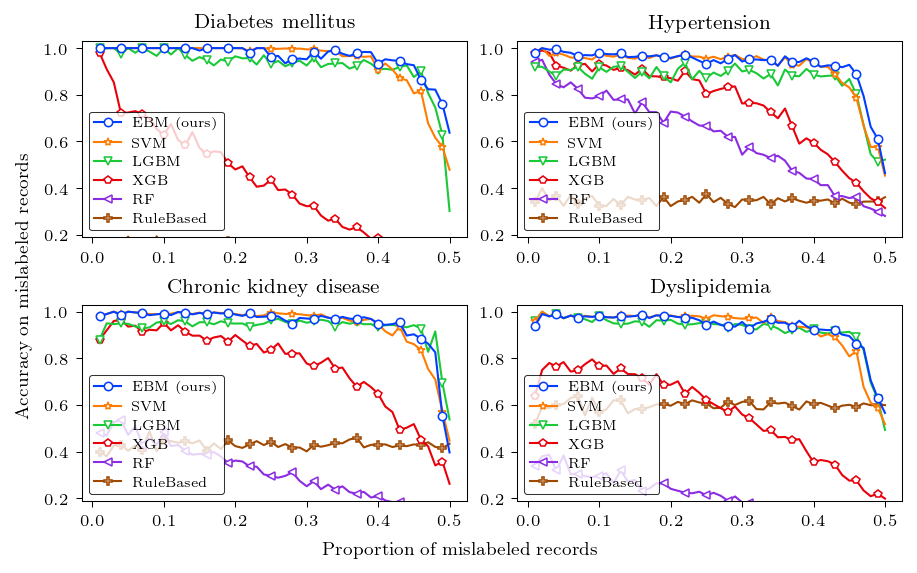

<Figure size 900x556.231 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tueplots import axes, bundles, cycler, figsizes, fonts, markers
from tueplots.constants import markers as marker_constants
from tueplots.constants.color import palettes


# Increase the resolution of all the plots below
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"figure.dpi": 150})
plt.rcParams.update(fonts.jmlr2001_tex(family="serif"))
plt.rcParams.update(bundles.jmlr2001(family="serif"))
plt.rcParams.update(figsizes.jmlr2001(nrows=2))
plt.rcParams.update(markers.inverted())
plt.rcParams.update(cycler.cycler(color=sns.color_palette("bright", 6), marker=marker_constants.o_sized[:6]))
plt.rcParams.update(axes.lines())
plt.rcParams.update(axes.grid(grid_alpha=0.7))
plt.rcParams.update({'legend.fontsize': 6.5,
                     'legend.handlelength': 2
                    }
                   )
  
N = 4
step_size = 5
n_samples = df.shape[0]
labels = {'DM': 'Diabetes mellitus', 'HTN': 'Hypertension', 
          'CKD': 'Chronic kidney disease', 'DLP': 'Dyslipidemia'}
models = ['EBM', 'SVM', 'LGBM', 'XGB', 'RF', 'rule']
lines = [None]*len(models)
yerrs = [None]*len(models)
fig, axes = plt.subplots(nrows=2, ncols=2)
plt.figure()

for ax,label in zip(axes.flatten(), labels):
    #plt.grid(axis='y')
    for i, model in enumerate(models):
        vals = np.array(ln_results[label][model]['mean'])
        stds = np.array(ln_results[label][model]['std'])
        errs = [stds, stds - np.maximum(vals + stds - 1, 0)]
        lines[i], = ax.plot(np.arange(step_size/n_samples, 0.51, step_size/n_samples), 
                            vals, 
                            alpha=1,
                            markersize=4,
                            markevery=3,
                            zorder=-i)

    ax.set_title(labels[label])
    ax.legend(lines, 
              ['EBM (ours)', 'SVM', 'LGBM', 'XGB', 'RF', 'RuleBased'], 
              loc='lower left')
    ax.set_ylim(0.19, 1.03)
    ax.set_yticks([0.2,0.4, 0.6,0.8, 1.0])

fig.supxlabel('Proportion of mislabeled records', fontsize=9)
fig.supylabel('Accuracy on mislabeled records', fontsize=9)
fig.savefig('label_noise_results_.pdf', bbox_inches='tight', format='pdf', dpi=1200)